# Lab4a NERC using a bidirectional Long-Short-Term-Memory (biLSTM) and Conditional Random Fields (CRF)

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Combining a bidirectional LSTM model and a CRF model. The so called LSTM-CRF is a state-of-the-art approach to named entity recognition.

We are going to use the implementation provided by the keras-contrib package, that contains useful extensions to the official keras package.

Credits:
* https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/


### Preparations


We are going to use the *keras* package to train a LSTM model on our data:

https://keras.io

You need to install a specific version of *keras* on your local machine. To know which version you may already have run:

> pip list | grep tensorflow

To install a specific version run:

> pip install keras==2.2.4

This will uninstall any other version you have.

As a backend, we also need a specific version of tensorflow:

https://www.tensorflow.org

> pip install tensorflow==1.12.0

We further need an extension to keras:

https://github.com/keras-team/keras-contrib

> pip install git+https://www.github.com/keras-team/keras-contrib.git


For evaluation of sequence tagging, we are going to use a pakage *seqeval* which was tested on CoNLL tasks:

https://github.com/chakki-works/seqeval

> pip install seqeval[cpu]


In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("../../../data/NERC_datasets/entity-annotated-corpus/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data = data.fillna(method="ffill")

data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [2]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [3]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. Note again that we want to capture strong sequence dependencies within sentence. We use the SentenceGetter class from the previous notebook to retrieve sentences with their labels.

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [5]:
getter = SentenceGetter(data)

In [6]:
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [7]:
sentences = getter.sentences
print(len(sentences))

47959


### Prepare the data

Now we introduce dictionaries of words and tags.

In [8]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
idx2word = {i: w 
            for i, w in enumerate(words, 1)}


tag2idx = {t: i for i, t in enumerate(tags)}

In [9]:
word2idx["Obama"]

7234

In [10]:
tag2idx["B-geo"]

9

Now we map the senctences to a sequence of numbers and then pad the sequence. Padding is required by *tensorflow* to make the vector representation the same size. We define a maximum size of a sentence of 75 tokens and extend shorter sentence with zero values (padding).

Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero.

In [11]:
max_len = 75

In [12]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

Using TensorFlow backend.
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/piek/opt/anaconda3/lib/python3.7/site-pa

We need to apply the pad_sequences function to both the data and the tags.

In [13]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

The first data item now looks as follows:

In [14]:
print(X[0])

[ 2648  8899 17436 32891  4078 11488  7729 29764  3213 11348 16589 24325
 14725 26234 24171 11348 15352  8899 34153 28339 16636  3255  6568 26475
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178]


It is a vector with 75 elements represented through numerical values.

In [15]:
X[0].shape

(75,)

In [16]:
print(word2idx.get("Obama"))

7234


The 75 tags that go with the first data item look as follows:

In [17]:
print(y[0])

[13 13 13 13 13 13  9 13 13 13 13 13  9 13 13 13 13 13  1 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13]


In [18]:
y[0].shape

(75,)

In [19]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

For training the biLSTM network we also need to change the labels y to categorial.

In [20]:
print(y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
y[0].shape

(75, 17)

We split in train and test set.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [36]:
print('Number of training instances:', len(X_tr))
print('Number of test instances:', len(X_te))

Number of training instances: 43163
Number of test instances: 4796


### Setup the CRF-LSTM

Now we can fit a LSTM-CRF network with an embedding layer.

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [25]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer

In [29]:
crf = CRF(n_tags)  # CRF layer assigning our defined tag set

In [30]:
out = crf(model)  # output

In [31]:
model = Model(input, out)

In [32]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


We are going to fit the model in a number of *epochs* on the training set *X_tr*, which is split into training (90%) and validation (10%).

In [34]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 200s 5ms/step - loss: 0.1121 - crf_viterbi_accuracy: 0.9683 - val_loss: 0.0436 - val_crf_viterbi_accuracy: 0.9849
Epoch 2/5
38846/38846 [==============================] - 212s 5ms/step - loss: 0.0332 - crf_viterbi_accuracy: 0.9878 - val_loss: 0.0283 - val_crf_viterbi_accuracy: 0.9891
Epoch 3/5
38846/38846 [==============================] - 209s 5ms/step - loss: 0.0241 - crf_viterbi_accuracy: 0.9903 - val_loss: 0.0250 - val_crf_viterbi_accuracy: 0.9898
Epoch 4/5
38846/38846 [==============================] - 194s 5ms/step - loss: 0.0209 - crf_viterbi_accuracy: 0.9912 - val_loss: 0.0236 - val_crf_viterbi_accuracy: 0.9899
Epoch 5/5
38846/38846 [==============================] - 194s 5ms/step - loss: 0.0191 - crf_viterbi_accuracy: 0.9919 - val_loss: 0.0221 - val_crf_viterbi_accuracy: 0.9906


### Some explanations:
ETA = estimated time of arrival
loss = loss during training tested on training data
crf_viterbi_accuracy = accuracy during training of the CRF to make the right sequence prediction in a Viterbi model of all possible sequences
val_loss = loss on the validation set (4317 instances) after training during the Epoch
val_crf_viterbi_accuracy = accuracy on the validation set (4317 instances)

The validation results are most important. We see that the loss decreases and the accuracy increases.

Note: if your validation loss/accuracy starts increasing while your training loss/accuracy is still decreasing, this is an indicator of overfitting.

Let's visualise the learning.

In [37]:
hist = pd.DataFrame(history.history)

In [39]:
hist.head

<bound method NDFrame.head of    val_loss  val_crf_viterbi_accuracy      loss  crf_viterbi_accuracy
0  0.043585                  0.984857  0.112127              0.968297
1  0.028333                  0.989073  0.033208              0.987826
2  0.024979                  0.989802  0.024141              0.990326
3  0.023562                  0.989919  0.020864              0.991233
4  0.022069                  0.990648  0.019116              0.991877>

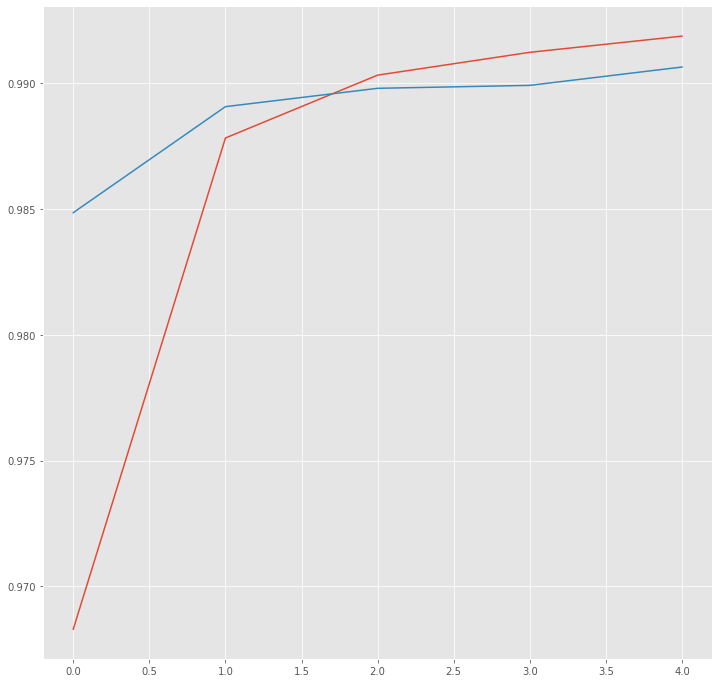

In [47]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"]) #blue line
plt.plot(hist["val_crf_viterbi_accuracy"]) #red line
plt.show()

The graph shows that the accuracy during training (blue) starts higher but does not grow as steep and flattens earlier than the accuracy on the validation set. This is a good sign.

## Evaluation on the hold out test set

For evaluation, we are going to use the *seqeval* package which is specifically designed for sequence annotations. 
In our case, it will return scores for he complete phrases instead of the IOB tags for the tokens. It also ignores the "O" tag which is dominant.

In [44]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [45]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 7s 1ms/step


Note that running a trained model on a test set is much faster and requires less cpu. 

We define a little function to get a sequence of tags from the gold data *y_te* and the system data *test_pred*.

In [57]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)  ### system data
test_labels = pred2label(y_te)  ### gold data

We use the function *precision_score*, *recall_score*, and *f1_score* from the *seqeval* package to get the overall sequence annotation results for the total set.

In [58]:
print("precision-score: {:.1%}".format(precision_score(test_labels, pred_labels)))
print("recall-score: {:.1%}".format(recall_score(test_labels, pred_labels)))
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

precision-score: 84.0%
recall-score: 81.3%
F1-score: 82.7%


This looks pretty good and it did require any feature engineering, as we did before for the CRF notebook in which we defined specific features. Remember that for the CRF with feature engineering and parameter optimalization, we obtained the following result:

* Before parameterization:
```
precision-score: 84.6%
recall-score: 83.2%
F1-score: 83.9%
```

* After parameterization:
```
precision-score: 76.5%
recall-score: 72.8%
F1-score: 74.6%
```

We can further improve the classifier by using word embeddings instead of token representations but also by adding character embeddings to the word embeddings. Character embedding capture many properties such as word shape, prefixes and suffixes, among others in an intituive way without define explicit features for these. Below is some literature on this approach.

References and further reading:

* Huang et. al: Bidirectional LSTM-CRF Models for Sequence Tagging [https://arxiv.org/pdf/1508.01991v1.pdf]
* Ma et al.: End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF [https://arxiv.org/pdf/1603.01354.pdf]


In [50]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      tim       0.89      0.83      0.86      2042
      geo       0.84      0.89      0.87      3680
      per       0.77      0.76      0.77      1693
      org       0.75      0.65      0.69      2065
      gpe       0.97      0.93      0.95      1569
      eve       0.50      0.17      0.25        30
      art       0.00      0.00      0.00        40
      nat       0.00      0.00      0.00        24

micro avg       0.84      0.81      0.83     11143
macro avg       0.83      0.81      0.82     11143



Finally, we inspect some predictions.

In [51]:
i = 1927
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Mr.            : B-per B-per
Fujimori       : I-per I-per
fled           : O     O
to             : O     O
Japan          : B-geo B-geo
in             : O     O
2000           : B-tim B-tim
amid           : O     O
charges        : O     O
of             : O     O
corruption     : O     O
and            : O     O
human          : O     O
rights         : O     O
abuses         : O     O
stemming       : O     O
from           : O     O
his            : O     O
10             : B-tim B-tim
years          : O     O
in             : O     O
office         : O     O
.              : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
crowns         : O     O
c

### Applying the model to an external sentence.

If we want to apply the above model to any text, we need to represent it as tokenized sentences and represent each sentence according to the vocabulary and with the right padding.

In [59]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

Now we transform every word to it’s integer index. Note that we mapping unknown words to zero. Normally you would want to add a UNKNOWN token to your vocabulary. Then you cut the vocabulary on which you train the model and replace all uncommon words by the UNKNOWN token. We haven’t done this for simplicity.

In [53]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [54]:
print(x_test_sent)

[[    0  2714   409   368  8899 11348 25516 32766 13561   409 31447 13581
   8899 11348 10981 11015  8899 13256 13561 26234   409 23438  8899 11348
   6391     0  8899 34413 13561 11348 26433 28471  1537 24325 11348 17966
  32116 26475     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]


And now we can predict with the model and see what we got.

In [55]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Hawking        : B-art
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : B-art
of             : O    
Freedom        : B-geo
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    


## End of this notebook